# Bootstrap Notebook

In [118]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import seaborn as sns
import scipy.io
import random
rc('text', usetex=True)
sns.set_style("whitegrid", {'axes.grid' : False})

class DataLoader:
    """
    Class for loading the MatLab data.
    """

    def __init__(self, file):
        """
        Load the data from the given file.

        :param file: Path to file to load the data from (without the .mat extension).
        :param flip_rate: Rate for flipping bits randomly, 0 means no flipping and 1 means all flipped and the
                          maximum entropy is obtained for flip_rate = 0.5.
        """
        self.data = scipy.io.loadmat(file, squeeze_me=True, struct_as_record=False)['mnist']
        self.train_images = self.data.train_images
        self.test_images = self.data.test_images
        self.train_labels = self.data.train_labels
        self.test_labels = self.data.test_labels

    def load_images(self, flip_rate=0):
        self.train_images = self.transform_images(self.train_images)
        self.test_images = self.transform_images(self.test_images)
        if flip_rate > 0:
            noise = np.random.binomial(1, flip_rate, self.train_images.shape) * -2 + 1
            self.train_images = np.multiply(self.train_images, noise)

    def transform_images(self, data):
        """
        Convert a (m x n x p) array to a (p x m x n) array and apply some additional transformations.

        :param data: Data to transform.
        :return: Transformed data.
        """
        reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        swapped_axes = np.swapaxes(reshaped, 0, 1)
        return (swapped_axes > 122) * 2 - 1
    
def calculate_normalizing_constant(samples, w, theta):
    return np.sum(np.exp(-calculate_energy(samples, w, theta)))

def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    # Also allow samples consisting of one sample (an array, so f.ndim == 1)
    # Therefore, only take the diagonal in the two dimensional case
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

def generate_samples(w, theta, num_burn_in=50, num_samples=500, show_transition_probabilities=False):
    num_neurons = w.shape[0]
    
    # Initialize a random sample
    s = np.random.binomial(1, 0.5, (num_neurons,)) * 2 - 1
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_samples):
        for burn_in in range(num_burn_in + 1):
            # Store the original value of s
            s_original = s
            # Calculate the flip probabilities
            p_flip = 0.5 * (1 + np.tanh(np.multiply(-s, np.dot(w, s) + theta)))
            # Calculate transition probabilities
            p_transition = p_flip / float(num_neurons)
            p_stay = 1 - np.sum(p_transition)
            # Flip according to the probability distribution of flipping
            if random.random() <= 1 - p_stay:
                # Pick a random neuron
                neuron = random.randint(1, num_neurons) - 1
                if random.random() <= p_flip[neuron]:
                    s[neuron] *= -1
            # Add the state if the sample is not generated during the burn in period
            if burn_in >= num_burn_in:
                if show_transition_probabilities:
                    print('Transition probabilities for ', s_original,':', p_transition, ' (stay probability: ', p_stay, ')')
                X = np.vstack([X, s])
    return X

def calculate_clamped_statistics(X):
    """
    Calculate <x_i>_c and <x_i x_j>_c given X.
    """
    num_datapoints = X.shape[0]
    return np.sum(X, axis=0) / num_datapoints, np.dot(X.T, X) / num_datapoints

def training_bm(num_burnin, num_samples):
    num_neurons = 10
    learning_rates = [0.05, 0.05]
    w = np.random.normal(0, 1, (num_neurons, num_neurons))
    w = np.tril(w) + np.tril(w, -1).T
    np.fill_diagonal(w, 0)
    theta = np.random.normal(0, 1, (num_neurons,))

    X_c = np.random.binomial(1, 0.5, (50, num_neurons)) * 2 - 1
    s1_c, s2_c = calculate_clamped_statistics(X_c)

    q = []
    for _ in range(150):
        X = np.zeros((0, num_neurons))
        for sample in range(num_samples):
            X = np.vstack([X, generate_samples(w, theta, num_burnin, 1)])
        Z = calculate_normalizing_constant(X, w, theta)
        p = calculate_probabilities(X, w, theta, Z)

        p_repeat = np.tile(p, (num_neurons, 1)).T
        Q = np.multiply(p_repeat, X)
        s2 = np.dot(X.T, Q)
        s1 = np.dot(p, X)

        dLdw = s2_c - s2
        dLdtheta = s1_c - s1
        np.fill_diagonal(dLdw, 0)

        delta_w = learning_rates[0] * dLdw
        delta_theta = learning_rates[1] * np.squeeze(np.asarray(dLdtheta))

        w += delta_w
        theta += delta_theta

        q.append([np.sum(np.abs(dLdw)), np.sum(np.abs(dLdtheta))])
    return np.matrix(q)
    
data = DataLoader('mnistAll')
data.load_images()

# Research Questions

## Sampling Procedure
- What is the effect of changing the number of burn-in samples and samples used in the sampling procedure on the convergence of the change in the weights during the learning procedure?

To answer this question, the learning rate is set to $0.05$. $10$ neurons are used and the training samples consist of $50$ random input patterns. The weights are initialized using a normal distribution with mean $0$ and variance $1$ and are made symmetric. The diagonal of the weights are set to $0$. The biases are initialized also using the same normal distribution.

It turned out that a low number of burn-in samples caused more variance in the change of weights while a high number of burn-in samples caused less variance in the change of weights.

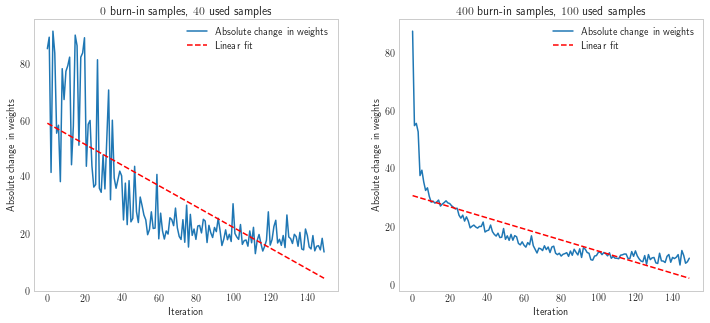

In [208]:
q = training_bm(0, 40)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fit = np.polyfit(np.arange(150), q[:, 0], 1, full=True)
ax[0].plot(q[:, 0], label='Absolute change in weights')
ax[0].plot(np.arange(150), fit[0][0] * np.arange(150) + fit[0][1], '--r', label='Linear fit')
ax[0].legend()
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Absolute change in weights')
ax[0].set_title('$0$ burn-in samples, $40$ used samples')

q = training_bm(400, 100)
fit = np.polyfit(np.arange(150), q[:, 0], 1, full=True)
ax[1].plot(q[:, 0], label='Absolute change in weights')
ax[1].plot(np.arange(150), fit[0][0] * np.arange(150) + fit[0][1], '--r', label='Linear fit')
ax[1].legend()
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Absolute change in weights')
ax[1].set_title('$400$ burn-in samples, $100$ used samples')

In [187]:
samples = [1, 20, 40, 60, 80, 100][::-1]
burn_ins = [0, 20, 40, 60, 80, 100]
results = np.zeros((len(samples), len(burn_ins)))

for i, sample in enumerate(samples):
    for j, burn_in in enumerate(burn_ins):
        print('(# burn_in, # samples) = (%d, %d)' % (burn_in, sample))
        for _ in range(1):
            q = training_bm(burn_in, sample)
            fit = np.polyfit(np.arange(150), q[:, 0], 1, full=True)
            slope = fit[0][0]
            results[i, j] = slope

(# burn_in, # samples) = (0, 100)
(# burn_in, # samples) = (20, 100)
(# burn_in, # samples) = (40, 100)
(# burn_in, # samples) = (60, 100)
(# burn_in, # samples) = (80, 100)
(# burn_in, # samples) = (100, 100)
(# burn_in, # samples) = (0, 80)
(# burn_in, # samples) = (20, 80)
(# burn_in, # samples) = (40, 80)
(# burn_in, # samples) = (60, 80)
(# burn_in, # samples) = (80, 80)
(# burn_in, # samples) = (100, 80)
(# burn_in, # samples) = (0, 60)
(# burn_in, # samples) = (20, 60)
(# burn_in, # samples) = (40, 60)
(# burn_in, # samples) = (60, 60)
(# burn_in, # samples) = (80, 60)
(# burn_in, # samples) = (100, 60)
(# burn_in, # samples) = (0, 40)
(# burn_in, # samples) = (20, 40)
(# burn_in, # samples) = (40, 40)
(# burn_in, # samples) = (60, 40)
(# burn_in, # samples) = (80, 40)
(# burn_in, # samples) = (100, 40)
(# burn_in, # samples) = (0, 20)
(# burn_in, # samples) = (20, 20)
(# burn_in, # samples) = (40, 20)
(# burn_in, # samples) = (60, 20)
(# burn_in, # samples) = (80, 20)
(# burn_i

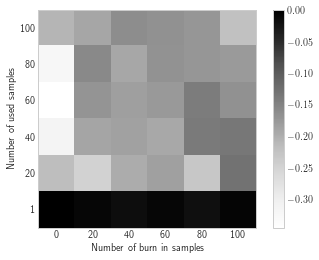

In [188]:
fig, ax = plt.subplots(1, 1)

ax.set_xlabel('Number of burn in samples')
ax.set_xticks(np.arange(-1, len(burn_ins), 1))
ax.set_xticklabels([''] + burn_ins)
ax.set_ylabel('Number of used samples')
ax.set_yticks(np.arange(-1, len(samples), 1))
ax.set_yticklabels([''] + samples)

plt.imshow(results)
plt.colorbar()

(60, 100)

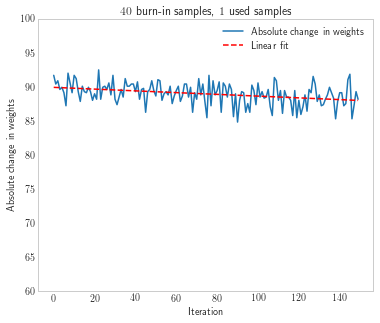

In [214]:
q = training_bm(40, 1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
fit = np.polyfit(np.arange(150), q[:, 0], 1, full=True)
ax.plot(q[:, 0], label='Absolute change in weights')
ax.plot(np.arange(150), fit[0][0] * np.arange(150) + fit[0][1], '--r', label='Linear fit')
ax.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Absolute change in weights')
ax.set_title('$40$ burn-in samples, $1$ used samples')
ax.set_ylim([60, 100])

## Optimal Noise Level

The questions are answered using MNIST data ($28 \times 28$ images), converted to binary pixels.

- What definition of noise is used?

<img src="img/noise-vs-accuracy.png" />

- Why is there a low mean accuracy for a noise level between $0.00$ and $0.03$ and for a noise level between $0.47$ and $0.50$?
- Using a classifier which randomly picks one digit of $\{0, 1, 2, ..., 9\}$, the mean accuracy will be $0.10$. Why is there a dip in accuracy lower than $0.10$ between $0.47$ and $0.50$?

### Noise definition
For each pixel, a noise mask is created. Every pixel in the mask has value $-1$ with probability $p_{\mbox{noise}}$ and value $1$ with probability $1 - p_{\mbox{noise}}$. Then, element-wise multiplication is applied on the original image with the mask.

For $p_{\mbox{noise}}=0$, there is no distortion of the original images. For $p_{\mbox{noise}}=1$, every bit is flipped and the structures in the original images remain. For $p_{\mbox{noise}}=0.5$, maximum noise is obtained and there is no structure in the images.

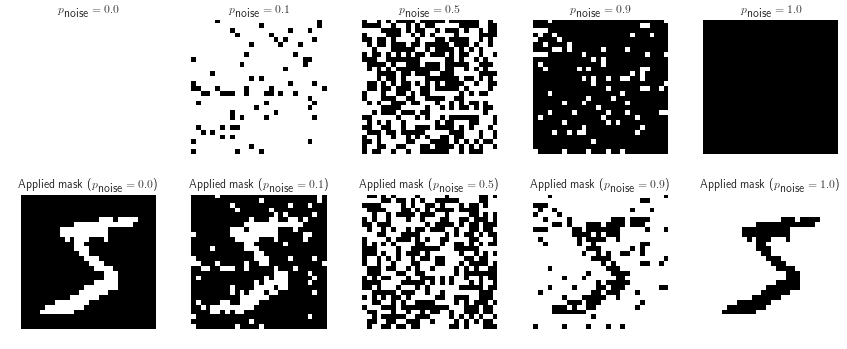

In [53]:
noise_levels = [0, 0.1, 0.5, 0.9, 1.0]

fig, ax = plt.subplots(nrows=2, ncols=len(noise_levels), figsize=(12, 5))
for index, noise_level in enumerate(noise_levels):
    noise_mask = np.random.binomial(1, noise_level, (28, 28)) * 2 - 1
    ax[0, index].set_title('$p_{\mbox{noise}}=%.1f$' % noise_level)
    ax[0, index].axis('off')
    ax[0, index].imshow(noise_mask, vmin=-1, vmax=1)
    ax[1, index].set_title('Applied mask ($p_{\mbox{noise}}=%.1f$)' % noise_level)
    ax[1, index].axis('off')
    ax[1, index].imshow(np.multiply(noise_mask, data.train_images[0, :].reshape(28, 28)), vmin=-1, vmax=1)
fig.tight_layout()

### Why is there a low accuracy for $0.00 \le p_{\mbox{noise}} \le 0.03$?

Because when there is a low noise level, there are pixels without any change. Take for example the left-most pixel in each image. This pixel is off in all the images. The learning algorithm cannot cope with constant pixels, so at least some noise should be added.

Then, there will be multiple zeroes on the diagonal of the $C$ matrix used in the learning procedure? In the learning procedure, this matrix is inverted. In some cases it will not be possible to invert this matrix because of these zeroes. That is one explanation for the low accuracy between $0.00$ and $0.03$.

### Dip at $0.48$ and accuracy at $0.50$
We could not find an explanation for the dip for $p_{\mbox{noise}} \approx 0.48$. The accuracy $0.10$ for $p_{\mbox{noise}} = 0.50$ is explained by the fact that since the image is completely random. Since the image is completely random, the classifier acts the same as a random guess. By chance, guessing the correct number is indeed $\frac{1}{10}$.